In [1]:
import numpy as np
import scipy as sp
from scipy import io,integrate,sparse,signal,interpolate
from numpy import polynomial

import matplotlib.pyplot as plt

import os,sys
sys.path.insert(0, '..')

from partial_trace import *
#from lanczos_bin import mystep,distribution

from IPython.display import clear_output
np.set_printoptions(linewidth=300)
%load_ext autoreload
%autoreload 2


In [2]:
plt.rcParams['text.latex.preamble'] = r'\renewcommand{\vec}{\mathbf}'
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('font',size=10)
plt.rc('xtick',labelsize=10)
plt.rc('ytick',labelsize=10)

$\renewcommand{\vec}{\mathbf}$

Now we will visualize the results of the experiment.

In [3]:
directory = f'data/KSC'
data_directory = 'data'

Let's load all of the data files. We'll then store the output of the experiment in a array called `out_all` and a list of the $h$ values in an array called `hs`. These will be sorted by the value of $h$.

In [4]:
# load parameters
[s,N,N_s] = np.load(f'{directory}/dimensions.npy',allow_pickle=True)
N = int(N)
N_s = int(N_s)

In [5]:
out_all_expr = {}
hs_expr = {}
J2_strength = .1

data_directory = f'data'

out_all = []
hs = []
for file in os.listdir(f'{directory}/{data_directory}'):
    
    # only look at npy files
    if file[-4:] != '.npy':
        continue
    
    data = np.load(f'{directory}/{data_directory}/{file}',allow_pickle=True).item()
    hs.append(data['h'])
    out_all.append(data['out'])

hs,out_all = zip(*sorted(zip(hs,out_all)))
hs = np.array(hs)

hs_full = np.linspace(hs[0],hs[-1],500)


Now we will process the data to compute the von Neumann entropy for each $h$ value at all of the specified $\beta$ values.

In [6]:
n_βs = 30
βs = np.hstack([[1e5,1e4],1/np.logspace(-3,1.5,n_βs-1)])

ρ_EVs_all = []
vN_entropy_all = []
for hi,h in enumerate(hs):

    (Λk,Tr_defl),(Θs,Tr_rems) = out_all[hi]
    E0 = Λk[0]

    ρ_EVs = get_ρ_EVs_all(Λk,Tr_defl,Θs,Tr_rems,E0,βs)
    ρ_EVs_all.append(ρ_EVs)
    
    vN_entropy = get_vN_entropy(Λk,Tr_defl,Θs,Tr_rems,E0,βs)
    vN_entropy_all.append(vN_entropy)

Finally, we're ready to plot. For each value of $\beta$ we can simply add a curve to our plot.
For this example, which is exactly solvable, we can also compute the exact values of the von Neumann entropy.

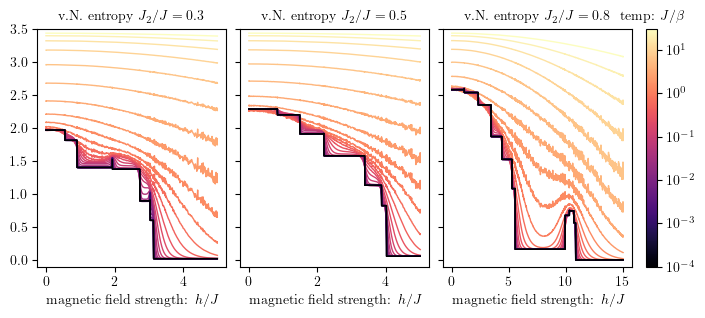

In [9]:
fig,axs = plt.subplots(1,4,figsize=(8,3.5),gridspec_kw={'width_ratios': [1,1,1,.06]})

αs = [3,5,8]
plt.subplots_adjust(bottom=.2,wspace=.1)

for αi,α in enumerate(αs):
    
    directory = f'data/final/KSC_J2_0{α}/KSC'

    # load parameters
    [s,N,N_s] = np.load(f'{directory}/dimensions.npy',allow_pickle=True)
    N = int(N)
    N_s = int(N_s)
    
    out_all_expr = {}
    hs_expr = {}
    J2_strength = .1
    
    data_directory = f'data'
    
    out_all = []
    hs = []
    for file in os.listdir(f'{directory}/{data_directory}'):
        
        # only look at npy files
        if file[-4:] != '.npy':
            continue
        
        data = np.load(f'{directory}/{data_directory}/{file}',allow_pickle=True).item()
        hs.append(data['h'])
        out_all.append(data['out'])
    
    hs,out_all = zip(*sorted(zip(hs,out_all)))
    hs = np.array(hs)
    
    hs_full = np.linspace(hs[0],hs[-1],500)
    
        
    n_βs = 30
    βs = np.hstack([[1e5,1e4],1/np.logspace(-3,1.5,n_βs-2)])
    
    ρ_EVs_all = []
    vN_entropy_all = []
    for hi,h in enumerate(hs):
    
        (Λk,Tr_defl),(Θs,Tr_rems) = out_all[hi]
        E0 = Λk[0]
    
        ρ_EVs = get_ρ_EVs_all(Λk,Tr_defl,Θs,Tr_rems,E0,βs)
        ρ_EVs_all.append(ρ_EVs)
        
        vN_entropy = get_vN_entropy(Λk,Tr_defl,Θs,Tr_rems,E0,βs)
        vN_entropy_all.append(vN_entropy)

    
    hs_full = np.linspace(hs[0],hs[-1],500)
    
    turning_points = np.load(f'{directory}/turning_points.npy')
    
    βs_to_int = lambda β: (np.log10(βs[1]) - np.log10(β)) / (np.log10(βs[1])-np.log10(βs[-1]))

    for l,β in enumerate(βs):
        c = plt.cm.magma(βs_to_int(β))
    
        # get y values for a single temperature
        y = np.array(vN_entropy_all)[:,l]
        axs[αi].plot(hs,y,color=c,lw=1,zorder=-l)
    

    cmap = plt.get_cmap('magma')
    sm = plt.cm.ScalarMappable(cmap=cmap)
    sm.set_array([])
    Ts = np.array([1e-4,1e-3,1e-2,1e-1,1e0,1e1,1e2])
    cbar = plt.colorbar(sm,ticks=βs_to_int(1/Ts),cax=axs[-1])
    cbar.ax.set_yticklabels([f'$10^{{{int(np.log10(T))}}}$' for T in Ts]);  # vertically oriented colorbar
    axs[-1].set_title('temp: $J/\\beta$',fontsize=10)
    
    axs[αi].set_ylim(-.1,3.5)
    axs[αi].set_xlabel('magnetic field strength: $h/J$')
        
#    axs[αi].text(.95,.95,rf,ha='right', va='top', transform=axs[αi].transAxes,bbox=dict(facecolor='white',edgecolor='none',pad=2))

    if αi>0:
        axs[αi].set_yticklabels([])

    axs[αi].set_title(f'v.N. entropy $J_2/J=0.{α}$',fontsize=10)

plt.savefig(f'imgs/vN_entropy_KSC.pdf')

/tmp/ipykernel_3519712/1160901069.py:68: RuntimeWarning: divide by zero encountered in log
  y = -(1/β)*np.log(ρ_EVs_all_trim[:,0])


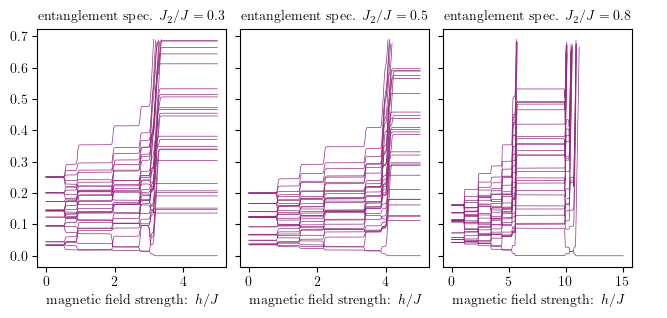

In [82]:
fig,axs = plt.subplots(1,4,figsize=(8,3.5),gridspec_kw={'width_ratios': [1,1,1,.06]},sharey=True)

αs = [3,5,8]
plt.subplots_adjust(bottom=.2,wspace=.1)

for αi,α in enumerate(αs):
    
    directory = f'data/final/KSC_J2_0{α}/KSC'

    # load parameters
    [s,N,N_s] = np.load(f'{directory}/dimensions.npy',allow_pickle=True)
    N = int(N)
    N_s = int(N_s)
    
    out_all_expr = {}
    hs_expr = {}
    J2_strength = .1
    
    data_directory = f'data'
    
    out_all = []
    hs = []
    for file in os.listdir(f'{directory}/{data_directory}'):
        
        # only look at npy files
        if file[-4:] != '.npy':
            continue
        
        data = np.load(f'{directory}/{data_directory}/{file}',allow_pickle=True).item()
        hs.append(data['h'])
        out_all.append(data['out'])
    
    hs,out_all = zip(*sorted(zip(hs,out_all)))
    hs = np.array(hs)
    
    hs_full = np.linspace(hs[0],hs[-1],500)
    
        
    n_βs = 30
    
    β = 50
    βs = [β]
    
    ρ_EVs_all = []
    vN_entropy_all = []
    for hi,h in enumerate(hs):
    
        (Λk,Tr_defl),(Θs,Tr_rems) = out_all[hi]
        E0 = Λk[0]
    
        ρ_EVs = get_ρ_EVs_all(Λk,Tr_defl,Θs,Tr_rems,E0,βs)
        ρ_EVs_all.append(ρ_EVs)
        
        vN_entropy = get_vN_entropy(Λk,Tr_defl,Θs,Tr_rems,E0,βs)
        vN_entropy_all.append(vN_entropy)

    
    hs_full = np.linspace(hs[0],hs[-1],500)
    
    turning_points = np.load(f'{directory}/turning_points.npy')
    
    βs = np.hstack([[1e5,1e4],1/np.logspace(-3,1.5,n_βs-1)])
    βs_to_int = lambda β: (np.log10(βs[1]) - np.log10(β)) / (np.log10(βs[1])-np.log10(βs[-1]))
    

    c = plt.cm.magma(βs_to_int(β))
    ρ_EVs_all_trim = np.array(ρ_EVs_all)*(np.array(ρ_EVs_all)>1e-15)
    y = -(1/β)*np.log(ρ_EVs_all_trim[:,0])
    axs[αi].plot(hs,y,color=c,lw=.5)
    axs[αi].set_title(f'entanglement spec. $J_2/J=0.{α}$',fontsize=10)
    
#    axs[αi].set_ylim(-.1,.9)
            
#    axs[αi].set_title(f'v.N. entropy $J_2/J=0.{α}$',fontsize=10)
    axs[αi].set_xlabel('magnetic field strength: $h/J$')

#    if αi>0:
#        axs[αi].set_yticklabels([])

    
axs[-1].axis('off')

plt.savefig(f'imgs/entanglement_spec_KSC.pdf')